# Chapter 8 - Tree Based Methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pydot
from IPython.display import Image

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report


%matplotlib inline
plt.style.use('seaborn-white')

In [7]:
# so dot.exe is found
import os
os.environ["PATH"] += os.pathsep + 'C:\\Users\\villanueva\\Anaconda3\\Library\\bin\\graphviz'

In [2]:
# This function creates images of tree models using pydot
def plot_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, 
                    feature_names=features, class_names=classn, 
                    filled=filled,
                    precision=2)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]
    return Image(graph.create_png())

In [19]:
df_hitters = pd.read_csv('Data/Hitters.csv', index_col=0).dropna()
df_hitters.index.name = 'Player'
df_hitters.index = df_hitters.index.map(lambda x: x.replace('-', '', 1))
df_hitters["League"] = df_hitters["League"].astype('category')
df_hitters["Division"] = df_hitters["Division"].astype('category')
df_hitters["NewLeague"] = df_hitters["NewLeague"].astype('category')
df_hitters.head(3)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N


## 8.1 The Basics of Decision Trees

### 8.1.1 Regression Trees

In [14]:
X = df_hitters[['Years', 'Hits']]
y = np.log(df_hitters.Salary)

In [15]:
# we can also use the option max_leaf_nodes=3 alone
regressionTree = DecisionTreeRegressor(max_depth=2, min_impurity_decrease=0.05)
regressionTree = regressionTree.fit(X, y)

#### FIGURE 8.1

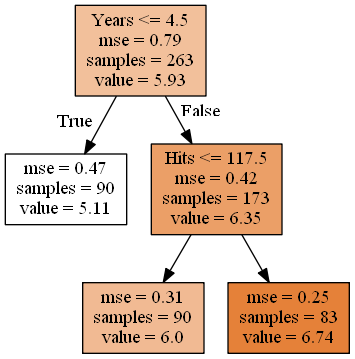

In [16]:
plot_tree(regressionTree, ['Years', 'Hits'])

#### FIGURE 8.2

In [17]:
lines = []
for node, feature in enumerate(regressionTree.tree_.feature):
    if feature != -2: # node
        lines.append((feature, regressionTree.tree_.threshold[node]))

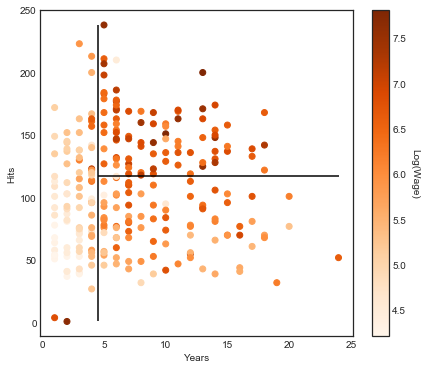

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
# the color indicates the value
sc = ax.scatter(X.Years, X.Hits, c=y, cmap='Oranges')
ax.set_ylabel('Hits')
ax.set_xlabel('Years')
# this algorithm doesn't really work for other cases...
last_threshold = None
for feature, threshold in lines:
    if feature == 0:
        if not last_threshold:
            ax.vlines(threshold, ymin=X.iloc[:,0].min(), ymax=X.iloc[:,1].max())
        else:
            ax.vlines(threshold, ymin=X.iloc[:,0].min(), ymax=last_threshold)
    else:
        if not last_threshold:
            ax.hlines(threshold, xmin=X.iloc[:,1].min(), xmax=X.iloc[:,0].max())
        else:
            ax.hlines(threshold, xmin=last_threshold, xmax=X.iloc[:,0].max())
    last_threshold = threshold
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('Log(Wage)', rotation=-90, va="bottom");

#### Tree Pruning

In [148]:
# try to emulate tree prunning using the maximum number of leaf nodes
feature_names = ['Years', 'RBI', 'Hits', 'PutOuts', 'Walks', 'Runs']
X = df_hitters[feature_names]
y = np.log(df_hitters.Salary)

In [149]:
scores = []
max_leafs_arr = range(2, 50)
for max_leafs in max_leafs_arr:
    regressionTree = DecisionTreeRegressor(max_leaf_nodes=max_leafs)
    sc = cross_val_score(regressionTree, X, y, cv=10, scoring="neg_mean_squared_error")
    scores.append((-sc.mean(), sc.std()))
scores = np.array(scores)

The best tree has 7 leafs.


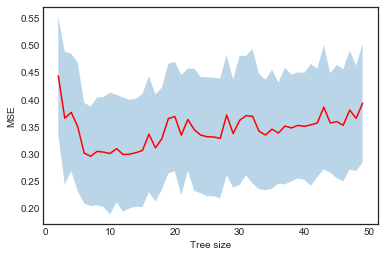

In [150]:
plt.plot(max_leafs_arr, scores[:,0], 'r')
plt.fill_between(max_leafs_arr, scores[:,0]+scores[:,1], scores[:,0]-scores[:,1], alpha=0.3)
plt.xlabel('Tree size')
plt.ylabel('MSE')
best_min_leafs = max_leafs_arr[np.argmin(scores[:,0])]
print(f"The best tree has {best_min_leafs} leafs.")

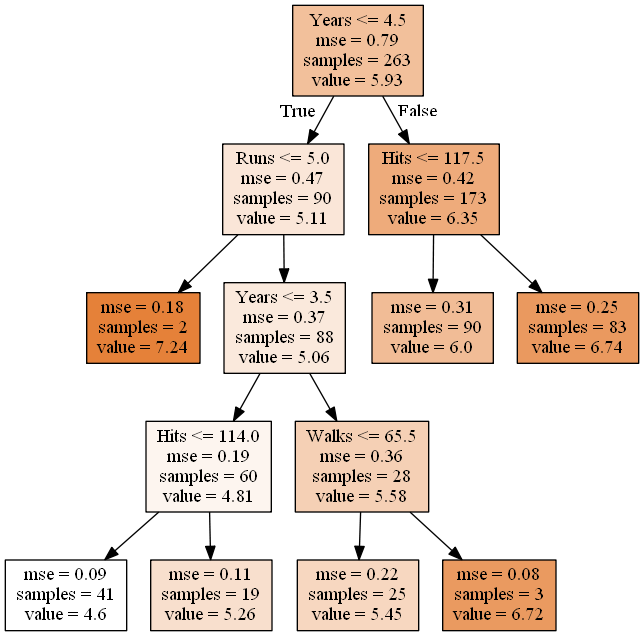

In [151]:
plot_tree(DecisionTreeRegressor(max_leaf_nodes=best_min_leafs).fit(X,y), feature_names)

#### The results are different than the book

### 8.1.2 Classification Trees

In [152]:
df_heart = pd.read_csv('Data/Heart.csv', index_col=0).dropna()
for cat_col in ['ChestPain', 'Thal', 'AHD']:
    df_heart[cat_col] = df_heart[cat_col].astype('category')
    print(f'{cat_col}: {df_heart[cat_col].cat.categories.values}')

ChestPain: ['asymptomatic' 'nonanginal' 'nontypical' 'typical']
Thal: ['fixed' 'normal' 'reversable']
AHD: ['No' 'Yes']


In [153]:
df_heart.head(3)

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes


In [157]:
X = pd.get_dummies(df_heart[df_heart.columns.difference(['AHD'])], drop_first=True)
y = pd.get_dummies(df_heart.AHD, drop_first=True)

In [158]:
X.head(3)

,Age,Ca,Chol,ExAng,Fbs,MaxHR,Oldpeak,RestBP,RestECG,Sex,Slope,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_normal,Thal_reversable
1,63,0.0,233,0,1,150,2.3,145,2,1,3,0,0,1,0,0
2,67,3.0,286,1,0,108,1.5,160,2,1,2,0,0,0,1,0
3,67,2.0,229,1,0,129,2.6,120,2,1,2,0,0,0,0,1


In [160]:
clf = DecisionTreeClassifier(max_depth=6, min_impurity_decrease=0.01)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.01, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

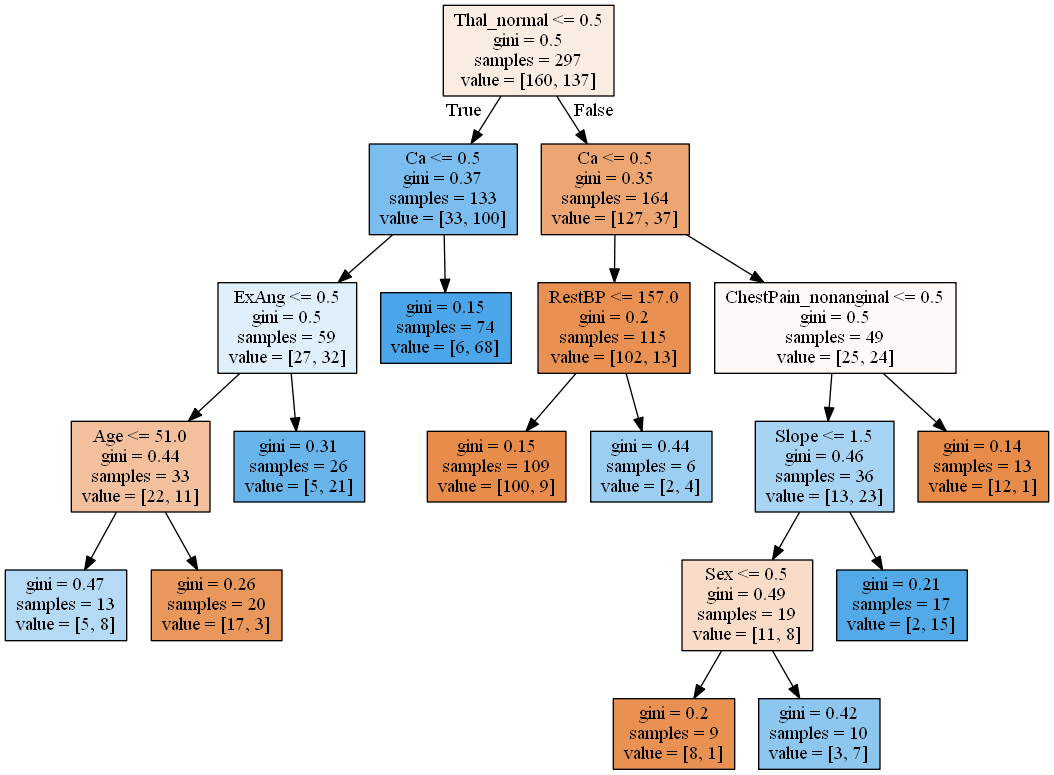

In [161]:
# unprunned tree
plot_tree(clf, X.columns)

In [205]:
scores = []
max_leafs_arr = range(2, 50)
for max_leafs in max_leafs_arr:
    regressionTree = DecisionTreeClassifier(max_leaf_nodes=max_leafs)
    sc = cross_val_score(regressionTree, X, y, cv=10)
    scores.append((sc.mean(), sc.std()))
scores = np.array(scores)

The best tree has 4 leafs.


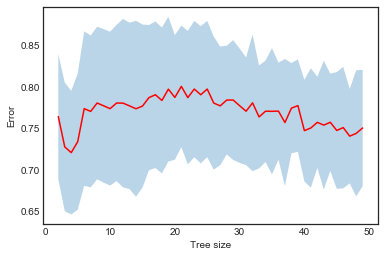

In [206]:
plt.plot(max_leafs_arr, scores[:,0], 'r')
plt.fill_between(max_leafs_arr, scores[:,0]+scores[:,1], scores[:,0]-scores[:,1], alpha=0.3)
plt.xlabel('Tree size')
plt.ylabel('Error')
best_min_leafs = max_leafs_arr[np.argmin(scores[:,0])]
print(f"The best tree has {best_min_leafs} leafs.")

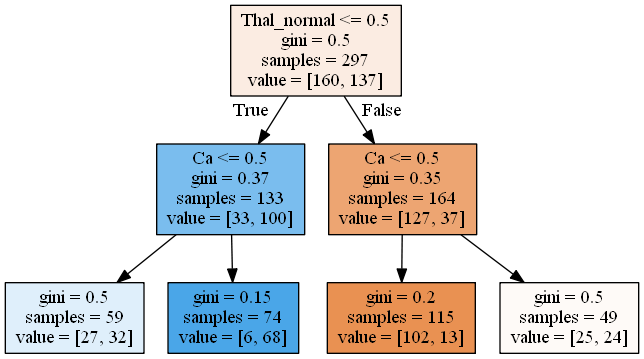

In [207]:
plot_tree(DecisionTreeClassifier(max_leaf_nodes=best_min_leafs).fit(X,y), X.columns)

#### Again, the best tree is different from the book